# Lab 10.9.2: A Multilayer Network on the MNIST Digit Data

## Attribution
- Original article by [Gregor Koehler](https://nextjournal.com/gkoehler/digit-recognition-with-keras) (17-02-2020).
- Remixed by Daniel Kapitan (08-01-2022):
  - updated code for Keras Tensorflow 
  - changed network layout with $K_1 = 256$ and $K_2 = 128$ units to match example in Introduction to Statistical Learning (2nd edition), figure 10.4

## Introduction
In this article we'll build a simple neural network and train it to recognize handwritten digits using the MNIST dataset. Training a *classifier* on the MNIST dataset is regarded as the *hello world* of image recognition. To follow along here, you should have a basic understanding of the [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) class of neural networks.

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

[Keras](https://keras.io) is a high-level neural network API focused on user friendliness, fast prototyping, modularity and extensibility. It works with deep learning frameworks like [Tensorflow](tensorflow.org), [Theano](http://deeplearning.net/software/theano/) and [CNTK](https://github.com/Microsoft/CNTK), so we can get right into building and training a neural network without a lot of fuss.

## Setting up and preparing the data

Let's get started by setting up our environment with Keras using Tensorflow as the backend. These package imports are pretty standard — we'll get back to the Keras-specific imports further down. Optionally we can also import the dataset to cache it.

In [1]:
# optionally cache the dataset
# %%sh
# python -c 'from tensorflow.keras.datasets import mnist
# mnist.load_data()'

In [2]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

# keras imports for the dataset and building our neural network
from keras_visualizer import visualizer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical

# load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Let's inspect a few examples. The MNIST dataset contains only grayscale images. For more advanced image datasets, we'll have the three color channels (RGB).

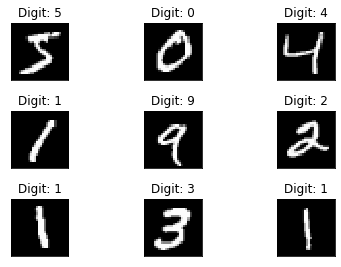

In [3]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

In order to train our neural network to classify images we first have to unroll the height $\times$width pixel format into one big vector - the *input vector*. So its length must be $28 \cdot 28 = 784$. But let's graph the distribution of our pixel values.

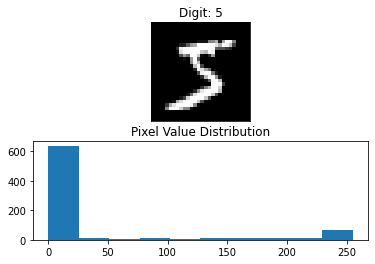

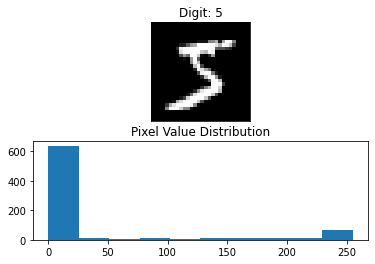

In [4]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

As expected, the pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.

Normalizing the input data helps to speed up the training. Also, it reduces the chance of getting stuck in local optima, since we're using stochastic gradient descent to find the optimal weights for the network.

Let's reshape our inputs to a single vector vector and normalize the pixel values to lie between 0 and 1.

In [5]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


So far the *truth* (*Y* in machine learning lingo) we'll use for training still holds integer values from 0 to 9.

In [6]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


Let's encode our categories - digits from 0 to 9 - using [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). The result is a vector with a length equal to the number of categories. The vector is all zeroes *except* in the position for the respective category. Thus a '`5`' will be represented by `[0,0,0,0,1,0,0,0,0]`.

In [7]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


## Building the network

Let's turn to Keras to build a neural network.

Our pixel vector serves as the input. Then, we instantiate two hidden node layers with 256 and128 units, respectively, which is sufficiently complex for recognizing digits. For the multi-class classification we add another *densely-connected* (or *fully-connected*) layer for the 10 different output classes. For this network architecture we can use the [Keras Sequential Model](https://keras.io/models/sequential/). We can stack layers using the `.add()` method.

When adding the first layer in the Sequential Model we need to specify the input shape so Keras can create the appropriate matrices. For all remaining layers the shape is inferred automatically. 

In order to introduce nonlinearities into the network and elevate it beyond the capabilities of a simple [perceptron](https://en.wikipedia.org/wiki/Perceptron) we also add activation functions to the *hidden layers.* The differentiation for the training via backpropagation is happening behind the scenes without having to implement the details. 

We also add *dropout* as a way to prevent overfitting. Here we randomly keep some network weights fixed when we would normally update them so that the network doesn't rely too much on very few nodes.

The last layer consists of connections for our 10 classes and the [softmax activation](https://en.wikipedia.org/wiki/Softmax_function) which is standard for multi-class targets.

In [8]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(256, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

visualizer(model, format='png')

![](graph.png)

## Compiling and training the Model

Now that the model is in place we configure the learning process using `.compile()`. Here we specify our *loss function* (or *objective function*). For our setting categorical cross entropy fits the bill, but in general other [loss functions](https://keras.io/losses/) are available. 

As for the [optimizer](https://keras.io/optimizers/) of choice we'll use [Adam](https://arxiv.org/abs/1412.6980v8) with default settings. We could also instantiate an optimizer and set parameters before passing it to `model.compile()` but for this example the defaults will do.

We also choose which metrics will be evaluated during training and testing. We can pass any list of [metrics](https://keras.io/metrics/) - even build metrics ourselves - and have them displayed during training/testing. We'll stick to *accuracy* for now.

In [9]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Having compiled our model we can now start the training process. We have to specify how many times we want to iterate on the whole training set (*epochs*) and how many samples we use for one update to the model's weights (*batch size*). Generally the bigger the batch, the more stable our stochastic gradient descent updates will be. But beware of (GPU) memory limitations! We're going for a batch size of 128 and 8 epochs.

To get a handle on our training progress we also graph the *learning curve* for our model looking at the loss and accuracy.

In order to work with the trained model and evaluate its performance we're saving the model in a `.h5` file.

In [10]:
%%time
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# save the model
model_name = 'keras_mnist.h5'
model.save(model_name)
print(f'Saved trained model at {model_name}')

Epoch 1/20
469/469 - 13s - loss: 0.3322 - accuracy: 0.9016 - val_loss: 0.1318 - val_accuracy: 0.9575
Epoch 2/20
469/469 - 7s - loss: 0.1399 - accuracy: 0.9580 - val_loss: 0.1016 - val_accuracy: 0.9690
Epoch 3/20
469/469 - 8s - loss: 0.1015 - accuracy: 0.9684 - val_loss: 0.0827 - val_accuracy: 0.9745
Epoch 4/20
469/469 - 8s - loss: 0.0832 - accuracy: 0.9748 - val_loss: 0.0767 - val_accuracy: 0.9762
Epoch 5/20
469/469 - 8s - loss: 0.0668 - accuracy: 0.9791 - val_loss: 0.0697 - val_accuracy: 0.9790
Epoch 6/20
469/469 - 8s - loss: 0.0568 - accuracy: 0.9820 - val_loss: 0.0680 - val_accuracy: 0.9791
Epoch 7/20
469/469 - 8s - loss: 0.0520 - accuracy: 0.9832 - val_loss: 0.0742 - val_accuracy: 0.9785
Epoch 8/20
469/469 - 8s - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.0667 - val_accuracy: 0.9799
Epoch 9/20
469/469 - 8s - loss: 0.0383 - accuracy: 0.9874 - val_loss: 0.0687 - val_accuracy: 0.9791
Epoch 10/20
469/469 - 8s - loss: 0.0352 - accuracy: 0.9882 - val_loss: 0.0673 - val_accuracy: 0.982

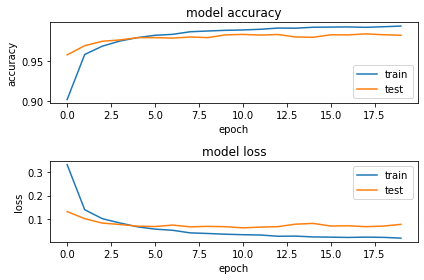

In [11]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
fig.show()

This learning curve looks quite good! We see that the loss on the training set is decreasing rapidly for the first two epochs. This shows the network is learning to classify the digits pretty fast. For the test set the loss does not decrease as fast but stays roughly within the same range as the training loss. This means our model generalizes well to unseen data.

## Evaluate the model's performance

It's time to reap the fruits of our neural network training. Let's see how well we the model performs on the test set. The `model.evaluate()` method computes the loss and any metric defined when compiling the model. So in our case the accuracy is computed on the 10,000 testing examples using the network weights given by the saved model.

In [12]:
mnist_model = load_model("keras_mnist.h5")
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

313/313 - 1s - loss: 0.0772 - accuracy: 0.9821
Test Loss 0.07720459252595901
Test Accuracy 0.9821000099182129


This accuracy looks very good! But let's stay neutral here and evaluate both correctly and incorrectly classified examples. We'll look at 9 examples each.


9821  classified correctly
179  classified incorrectly

Correct predictions
Incorrect predictions


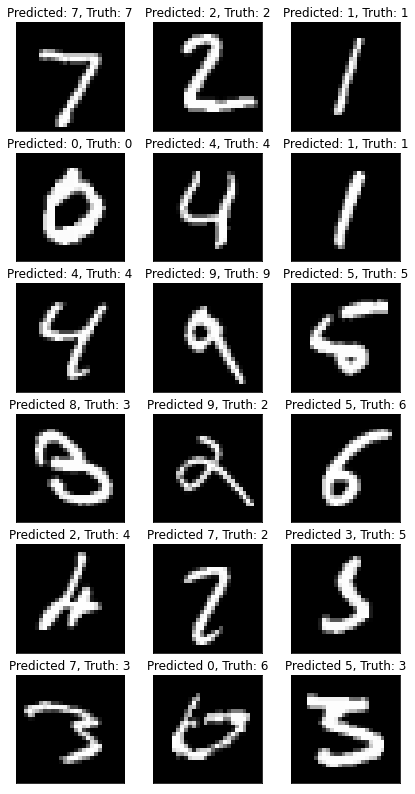

In [23]:
# load the model and create predictions on the test set
mnist_model = load_model("./keras_mnist.h5")
predicted_classes = np.argmax(mnist_model.predict(X_test), axis=-1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation.show()

As we can see, the wrong predictions are quite forgiveable since they're in some cases even hard to recognize for the human reader. 

In summary we used Keras with a Tensorflow backend on simpel CPU to train a neural network to recognize handwritten digits in under 3 minutes of training time - all that without having to spin up any compute instances, only using our browser.

In the next article of this series (coming soon) we'll harness the power of GPUs even more to train more complex neural networks which include [convolutional layers](https://en.wikipedia.org/wiki/Convolutional_neural_network).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c30c8c1-17cd-4c26-8a8f-ccfb4d164d7c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>